## Probabilistic convergence


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbySuwichaya/Estimation-Theory-EE523/blob/master/Tutorial3/main.ipynb)

by *Suwichaya Suwanwimolkul, Ph.D.*

The coding exercies and examples are used as parts of  *Probabilistic Convergence* in **Estimation Theory EE2102523**. 

The topics covered in this exercise are: 
- [Convergence in Distribution](#convergences-in-distribution)
    - [Simulation of Central Limit Theorem](#simulation-of-central-limit-theorem-bernoulli--uniform)
    - [KL Divergence](#kl-divergence)
- [Convergence in Probability](#convergence-in-probability)
    - [Simulation of Lecture II Example](#simulation-of-example---noise-in-lecture-2)
- [Almost Sure Convergence](#almost-surely-converge)
    - [Converge almost completely](#converges-almost-completely)
    - [Simulation of HW 2.2](#simulation-for-the-3rd-question-of-example-16) 

## Convergences in Distribution

Random variables $X_1, X_2, X_3, ...$ **converge in distribution**  to a random variable $X$, shown by $X_n \xrightarrow{d} X$, if the CDF  of X_n  converges to X as $n \rightarrow \infty$, or, for all $x$
\begin{equation}
    \lim_{n\rightarrow \infty}  F_{X_n} (x) = F_{X} (x).
\end{equation}


#### Applications
- **Central Limit Theorem:** The sum of RVs will eventually converges to the normal distribution, as the sample is getting large.   
- **Fist Dist:** Fitting the distribution to your dataset  

### Simulation of Central Limit Theorem: Bernoulli / Uniform

In [ ]:
! pip install numpy pandas tqdm matplotlib joypy

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import os
import joypy
 
cwd = os.getcwd()  

In [3]:
################################################  CTL_simulation Code for Simulation ##########################################

def KL_expo(ZN_prob, GAUSS_prob, nmu=0, nsigma=1): 
    KL = np.sum(GAUSS_prob * np.log(GAUSS_prob / ZN_prob))
    return KL

def CTL_simulation(N_round=2, N_size= 1000, orginal_distribution="Bernoulli", dirpath=None, hide_showplots=False):
    XN = 0
    if orginal_distribution == "Bernoulli":
        
        p  = 0.5
        
        MU_Xi  = p
        STD_Xi = np.sqrt(p*(1-p))

        for count_round in range(N_round):
            XN += np.random.binomial(size=N_size, p=p, n=1) 

    else:
        a = 0 
        b = 1 

        MU_Xi  = 0.5*(a + b)
        STD_Xi = np.sqrt((1/12)*(b - a)**2 )

        for count_round in range(N_round):
            XN += np.random.uniform(a,b,N_size)


    # Calculated emperical mean 
    mean_emp = np.mean(XN) 
    std_emp  = np.std(XN)

    # Calculated true mean 
    mu = N_round*MU_Xi  
    sigma =  np.sqrt(N_round)*STD_Xi  

    # Normalize
    ZN = (XN - mu) / sigma

    # Gaussian samples
    gauss = np.random.standard_normal(N_size)
    nsigma = 1
    nmu = 0  

    ############################## Printing & Plotting ############################
    if not(hide_showplots):
        print("Mean per RV $\mu_x$: %.2f"  % MU_Xi)
        print("Std  per RV $\sigma_x$: %.2f" % STD_Xi)

        print('==============================')

        print("N round: %d" % N_round) 

        print("Empirical Mean: %.2f"  % mean_emp)
        print("Empirical std: %.2f" % std_emp) 

        print("True Mean ($n \mu_x$): %.2f"  %  mu)
        print("True standard deviation ($\sqrt{n} \sigma_x$): %.2f"  % sigma)

        print('==============================')

        print("Normalized Mean: %.2f"  % np.mean(ZN))
        print("Normalized std: %.2f" % np.std(ZN)) 
 

    # Plotting

    plt.figure(figsize=(10,7))
    
    count, bins, ignored = plt.hist(gauss, np.arange(-3, 3 + 0.2, 0.2), alpha=0.8, color="orange" , density=True, label="Normal Samples")
    plt.plot(bins, 1/(nsigma * np.sqrt(2 * np.pi)) *  np.exp( - (bins - nmu)**2 / (2 * nsigma**2) ),  linewidth=3, color='r', label="Standard Normal") 
    count_Zn, bins_Zn, ignored_Zn = plt.hist(ZN, np.arange(-3, 3 + 0.2, 0.2), alpha=0.5, color="Navy" , density=True, label="Zn (CTL)")
    
    
    KL_scores = KL_expo(count_Zn + 1e-6, count + 1e-6 , nmu=0, nsigma=1)
    if not(hide_showplots):
        print("KL %.2f" % KL_scores )

    textstr = '\n'.join([ 
        "N round: "+ str(N_round),  
        "Normalized Mean: %.2f"  % np.mean(ZN), 
        "Normalized std: %.2f" % np.std(ZN),
        "KL Divergence: %.2f" % KL_scores])

    plt.legend() 
    plt.text( -2.85, 0.95, textstr,horizontalalignment='left', verticalalignment='top', family='monospace')
    plt.ylabel("Freq. (Density)")
    plt.xlabel("Samples")
    plt.title("CTL at N=%d from %s" % (N_round, orginal_distribution))
    plt.xlim(-3,3)
    plt.ylim(0,1.0)
    plt.savefig(os.path.join(dirpath, "CLT_N%d_%s.pdf" % (N_round, orginal_distribution)))
    plt.savefig(os.path.join(dirpath, "CLT_N%d_%s.png" % (N_round, orginal_distribution)))
    if not(hide_showplots):
        plt.show() 
    plt.close('all')

    return KL_scores

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_22884/1612983079.py:48: SyntaxWarning: invalid escape sequence '\m'
  print("Mean per RV $\mu_x$: %.2f"  % MU_Xi)
/tmp/ipykernel_22884/1612983079.py:49: SyntaxWarning: invalid escape sequence '\s'
  print("Std  per RV $\sigma_x$: %.2f" % STD_Xi)
/tmp/ipykernel_22884/1612983079.py:58: SyntaxWarning: invalid escape sequence '\m'
  print("True Mean ($n \mu_x$): %.2f"  %  mu)
/tmp/ipykernel_22884/1612983079.py:59: SyntaxWarning: invalid escape sequence '\s'
  print("True standard deviation ($\sqrt{n} \sigma_x$): %.2f"  % sigma)


### Apply Central Limit Theorem 

Mean per RV $\mu_x$: 0.50
Std  per RV $\sigma_x$: 0.50
N round: 50
Empirical Mean: 24.89
Empirical std: 3.49
True Mean ($n \mu_x$): 25.00
True standard deviation ($\sqrt{n} \sigma_x$): 3.54
Normalized Mean: -0.03
Normalized std: 0.99
KL 17.20


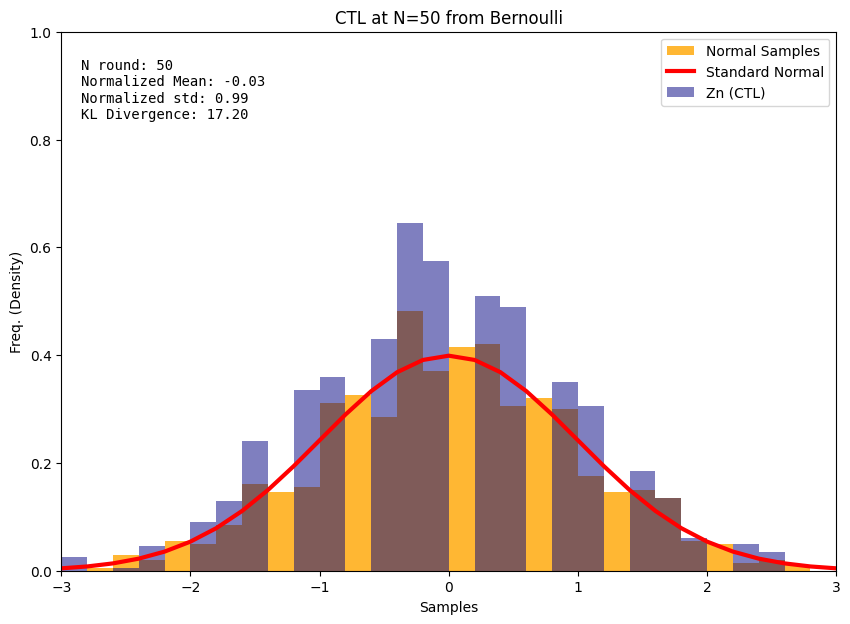

In [4]:
########################## The Central Limit Theorem ##########################
# Show that: the sum of RVs will eventually converges to the normal distribution, 
# as the number of sum is getting large.   

N_round = 50 # the number of sum << Vary this one 
N_size  = 1000


orginal_distribution = "Bernoulli" # {"Bernoulli" | "Uniform"}


dirpath = os.path.join(cwd, orginal_distribution)
os.makedirs(dirpath, exist_ok=True)

KL_scores = CTL_simulation(N_round=N_round, N_size= N_size, orginal_distribution=orginal_distribution, dirpath=dirpath)

### KL divergence

We can measure the convergence in distribution using KL divergence... 

\begin{equation}
KL(P||Q) = \sum_{x \in X} P(x) \log(\frac{P(x)}{Q(x)})
\end{equation}
where $P(x)$ denotes the probability of $X=x$ corresponding to the reference and $Q(x)$ denotes the probability of $X=x$ corresponding to the target.  

In the following, we compare the convergence of Bernoulli vs Uniform R.V. towards Normal distribution. 

- To compute $KL(P||Q)$, we will use `np.histogram` to provide $P(x)$ for the reference (normally distributed samples).

- Then, $Q(x)$ will be computed by `np.histogram`whose inputs are the samples that are originally simulated from the Bernoulli/Uniform distribution.

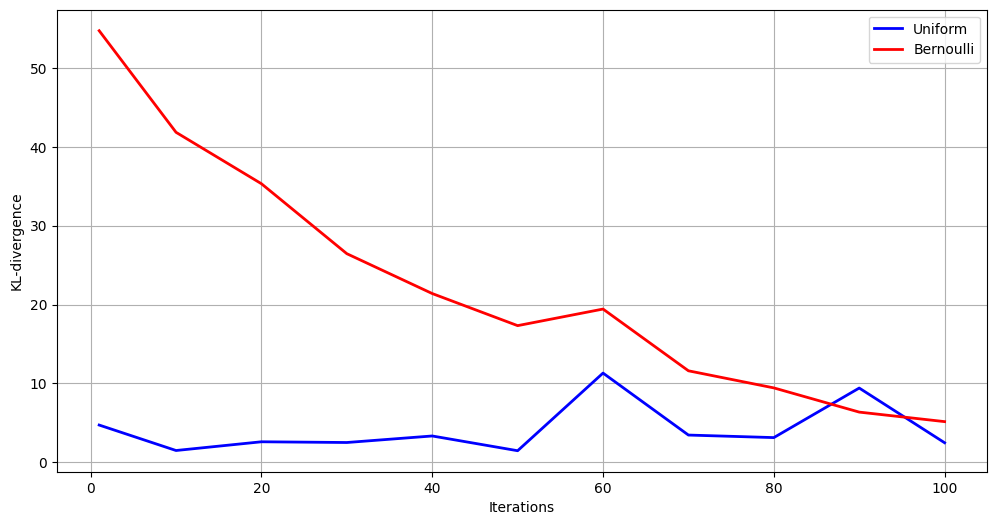

In [5]:
dirpath = os.path.join(cwd, "comparison-U-B")
os.makedirs(dirpath, exist_ok=True)

N_size = 100
N_list = [1,10,20,30,40,50,60,70,80,90,100]
KL_scores_bernoulli_list = []
KL_scores_uniform_list = []

for N in N_list:
    KL_scores_uniform   = CTL_simulation(N_round=N, N_size= N_size, orginal_distribution="Uniform", dirpath=dirpath, hide_showplots=True)
    KL_scores_bernoulli = CTL_simulation(N_round=N, N_size= N_size, orginal_distribution="Bernoulli", dirpath=dirpath, hide_showplots=True)
    KL_scores_uniform_list.append(KL_scores_uniform)
    KL_scores_bernoulli_list.append(KL_scores_bernoulli)

plt.figure(figsize=(12,6))
plt.plot(N_list, KL_scores_uniform_list, color="blue", linewidth=2, label="Uniform")
plt.plot(N_list, KL_scores_bernoulli_list, color="red", linewidth=2, label="Bernoulli")
plt.ylabel("KL-divergence")
plt.xlabel("Iterations")
plt.grid()
plt.legend()
plt.show()

## Convergence in Probability

Random variables $X_1, X_2, X_3, ...$ **converge in probability**  to a random variable $X$, shown by $X_n \xrightarrow{p} X$, if for any $\epsilon > 0$
\begin{equation}
    \lim_{n\rightarrow \infty}  P(|X_n - X| \geq \epsilon) = 0.
\end{equation}


#### Applications
- **Consistency of estimators:**  see Lecture 1 / Tutorial 1
- **Weak law of large numbers:**  states that the average of a large number of i.i.d. random varaibles converges to the expected value.

### Simulation of `Example - Noise` in Lecture 2 

Let $X$ be a random variable and $X_n = X + Y_n$ where $E[Y_n] = \frac{1}{n}$ and $Var[Y_n]=\frac{\sigma^2}{n}$ where $\sigma^2 > 0$ is a positive constant.    

We will further assume the followings: 
- $Y_n$ came from a Gaussian distribution with mean $E[Y_n] = \frac{1}{n}$ and $Var[Y_n]=\frac{\sigma^2}{n}$
- $X$ is a uniform distribution ranging from $a=0$ and $b=1$.

We will show that $\lim_{n\rightarrow \infty}  P(|X_n - X| \geq \epsilon) = 0$... in the following steps:
- Show histrogram of $X_n$ and $X$ at different  $n$  (or `N_select`). 
- Then, let $ B_n = |X_n - X| \geq \epsilon $, we show $P(B_n)$... 

In [6]:
def simulate_Xn( mu, sigma, N_size=1000):
    X  = np.random.uniform(-15,15,N_size)
    Yn = np.random.normal(mu, sigma, N_size)
    Xn = X + Yn
    return Xn, X, Yn

<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:29: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_22884/3081943179.py:28: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$|X_n-X| \geq \epsilon$")
/tmp/ipykernel_22884/3081943179.py:29: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Show  $P(|X_n-X| \geq \epsilon)$ ")


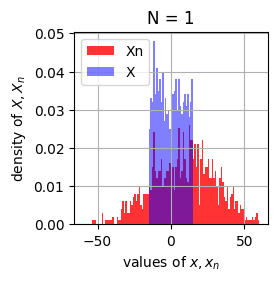

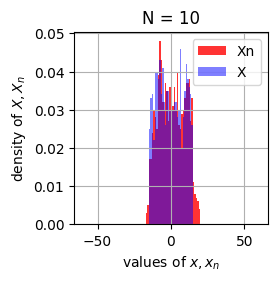

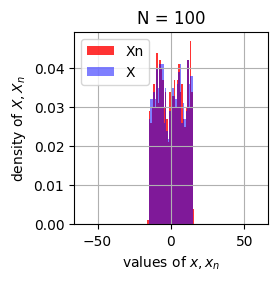

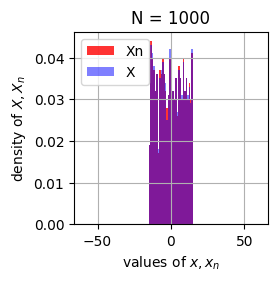

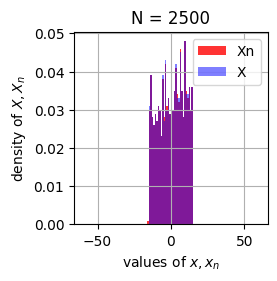

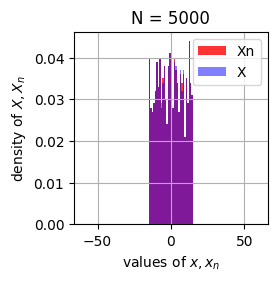

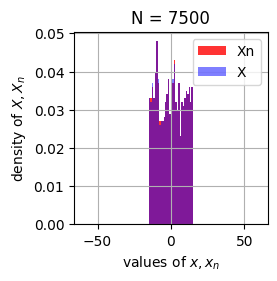

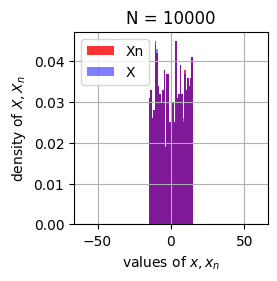

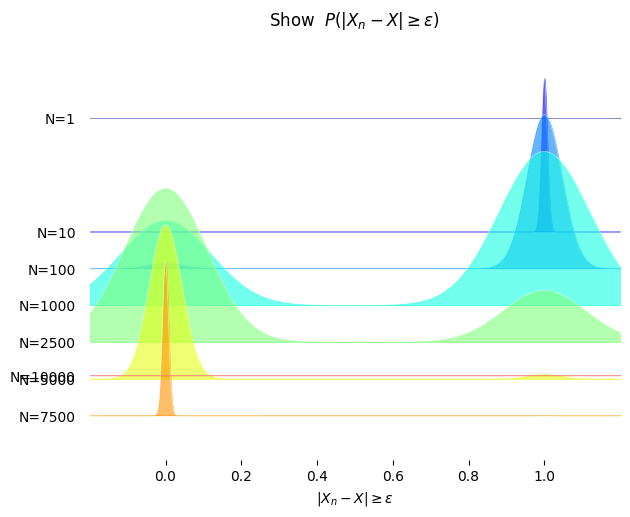

In [7]:
N_list = [1,10,100,1000,2500,5000,7500,10000]
 
df_Xn_vs_X_logics = {}

for N_select in N_list: 
    mu      = 10/N_select 
    sigma   = 20/N_select 
    Xn, X, Y = simulate_Xn( mu, sigma, N_size=1000)

    # Show histrogram of $X_n$ and $X$ at different  $n$  (or `N_se Examples lect`). 
    plt.close('all')
    plt.figure(figsize=(2.5,2.5))
    Xn_count,  Xn_bins,  Xn_ignored  = plt.hist(Xn, bins=np.arange(-60, 60 + 0.2, 1), alpha=0.8, color="red" , density=True, label="Xn") 
    X_count,  X_bins,  X_ignored     = plt.hist(X,  bins=np.arange(-60, 60 + 0.2, 1), alpha=0.5, color="blue" , density=True, label="X")
    plt.legend()
    plt.grid()
    plt.ylabel("density of $X, X_n$")
    plt.xlabel("values of $x, x_n$")
    plt.title("N = %d" % N_select)
    plt.show()

    diff_Xn_vs_X = Xn - X 
    df_Xn_vs_X_logics["N=%d" % int(N_select)] = 1.0*(np.absolute(diff_Xn_vs_X) > 1e-2)

 
# Let $ B_n = |X_n - X| \geq \epsilon $, we show $P(B_n)$
joypy.joyplot(df_Xn_vs_X_logics, overlap=2, hist=False, colormap=cm.jet, alpha=0.6, linecolor='w', linewidth=.5, xlabels=True, ylabels=True, ylim='mean')
plt.xlabel("$|X_n-X| \geq \epsilon$") 
plt.title("Show  $P(|X_n-X| \geq \epsilon)$ ") 
plt.show()

## Almost Surely Converge

 The sequence $X_n$ **converges almost surely** (converges with probability 1) towards $X$, if
\begin{equation}
	P \left( \lim_{n\rightarrow \infty} X_n = X \right) = 1 .
\end{equation}

### Strong Law of Large Number

Let $X_1, X_2, ... X_n$ be i.i.d. random variables with a finite expected value $E[X_i] = \mu \leq \infty$.  Then, $\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i $
	
\begin{equation}
		P(\lim_{n \rightarrow \infty} \bar{X}_n   = \mu) = 1
\end{equation}

or $\bar{X}_n \xrightarrow{a.s.} \mu$

To show this, we know that $\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i $ is actually a sample mean estimator. To confirm that $\bar{X}_n \xrightarrow{a.s.} \mu$ is to show that $\lim_{n\rightarrow \infty} \bar{X}_n = \mu$ or $\lim_{n\rightarrow \infty} \bar{X}_n - \mu = 0$. This is very difficult to prove mathemtically. 

Therefore, in some cases, it is easier to consider the following lemma to show $a.s.$ convergence. 

### Converges almost completely

For all $\epsilon > 0$, we say that $X_n$ **converges almost completely** towards $X$,, ie,  
\begin{align}
    \sum_{n=1}^{\infty}	P( |X_n - X| > \epsilon ) < \infty;
\end{align}
then, $X_n \xrightarrow{a.s.} X$.

### Simulation for Homework 4

If random variables $X_1, X_2, X_3, ... $ be a sequence of i.i.d.   $Bernoulli (1/n)$.  

Questions:
- 1. Verify if  $X_n \xrightarrow{d} 0 $,  that is, $\lim_{n \rightarrow \infty} F_{X_n}(x) = F_{X}(x=0)$?  (5 scores) 
- 2. Verify if $X_n \xrightarrow{p} 0 $,  that is,, $\lim_{n\rightarrow\infty} P( |X_n - 0|  \geq \epsilon) = 0$ ?  (5 scores)  
- 3. Verify if $X_n \xrightarrow{a.s.} 0 $,  that is,, $P(\lim_{n \rightarrow \infty} X_n   = 0) = 1$ ?  .... $\Rightarrow$ Hint it is easier to use **converges almost completely**  
        Show both 1. theoretical prooof and 2. simulation for the full score.  (5 scores)  

From above definition, we have to show $\sum_{n=1}^{\infty}	P( |X_n - X| > \epsilon ) = \sum_{n=1}^{\infty} P( |X_n| > \epsilon ) < \infty$.

Therefore, we will do the following: 
- Provide histrogram density of $|X_n| > \epsilon $
- Compute the summation at different $n$
- Check if the resulting summation is decreasing... 

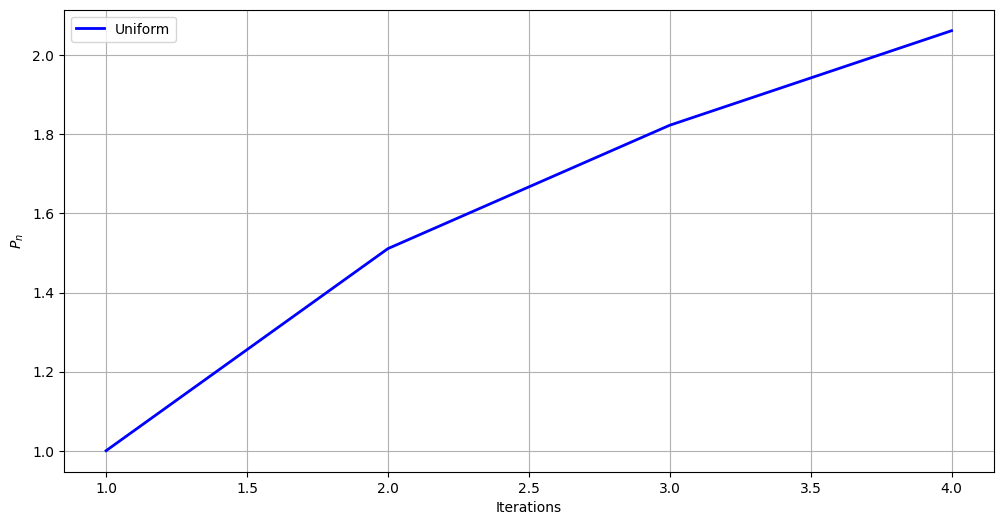

In [8]:
# Provide histrogram density of $|X_n| > \epsilon $
N_list = np.arange(1, 5, 1).tolist() # < You have to change this ... Just look at the formular .. what is the range of n.. 
P_count_n = []
P_count_temp = 0
N_size=1000

for N_select in N_list:   
    XN = np.random.binomial(size=N_size, p=1/N_select, n=1) 
    counts = 1*(XN > 0) 

    P_count = counts.sum()/N_size
    P_count_temp += P_count 
    P_count_n.append(P_count_temp)   
     

P_count_n
plt.figure(figsize=(12,6))
plt.plot(N_list, P_count_n, color="blue", linewidth=2, label="Uniform") 
plt.ylabel("$P_n$")
plt.xlabel("Iterations") 
plt.grid()
plt.legend()
plt.show()